# Learning a sensorimotor model with a context

# I. Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from explauto import Environment
arm = Environment.from_configuration('simple_arm', 'low_dimensional')

Let's define a variation of the SimpleArm environment to enable $\Delta$ actions.

In [3]:
from explauto.environment.context_environment import ContextEnvironment
from explauto.environment.simple_arm import SimpleArmEnvironment
from explauto.environment import environments

env_cls = SimpleArmEnvironment
env_conf = environments['simple_arm'][1]['low_dimensional']

context_mode = dict(choose_m=True,
                    context_dims=[0,1],
                    rest_position=[0]*3,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

environment = ContextEnvironment(env_cls, env_conf, context_mode)

Populating the interactive namespace from numpy and matplotlib


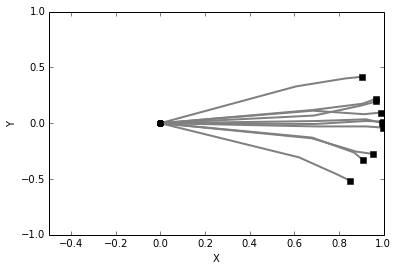

In [4]:
# Create the axes for plotting:
%pylab inline
ax = axes()

motor_configurations = environment.random_motors(n=10) / 2

# Plotting 10 random motor configurations:
for m in motor_configurations:
    environment.update(m, reset=False)
    environment.plot(ax)

# II. Sensorimotor model with action context

Now the database contains tuples of $(M, \Delta M, S, \Delta S)$ so we adapt the sensorimotor model dimensions.

NN, LWLR-BFGS, LWLR-CMAES (TODO check sigma)

In [5]:
from explauto import SensorimotorModel
from explauto.utils.config import make_configuration
import numpy as np

conf = make_configuration(np.hstack((arm.conf.m_mins, arm.conf.m_mins / 4)), 
                          np.hstack((arm.conf.m_maxs, arm.conf.m_maxs / 4)),
                          np.hstack((arm.conf.s_mins, arm.conf.s_mins / 4)),
                          np.hstack((arm.conf.s_maxs, arm.conf.s_maxs / 4)))

sm_model = SensorimotorModel.from_configuration(conf, 'NN', 'default')

Populating the interactive namespace from numpy and matplotlib
Size of database: 200


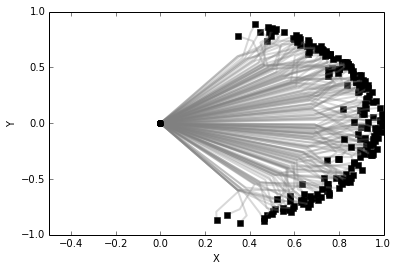

In [6]:
# Create the axes for plotting:
%pylab inline
ax = axes()

for mdm in environment.random_motors(n=200):
    context = environment.current_sensori_position
    sds = environment.update(mdm, reset=True)    
    sm_model.update(mdm, sds)
    environment.plot(ax, alpha=0.3)
    #draw()
    
print "Size of database:", sm_model.size()

# III. Goal babbling using interest models

Random, Discretized, TODO Tree

In [7]:
from explauto.interest_model.discrete_progress import DiscretizedProgress, competence_dist

im_model = DiscretizedProgress(conf, conf.s_dims, **{'x_card': 1000,
                                                     'win_size': 10,
                                                     'measure': competence_dist})

In [8]:
# Or with Random interest model
from explauto.interest_model.random import RandomInterest
im_model = RandomInterest(conf, conf.s_dims)

Sampling with context:

In [9]:
c = [0.7, 0.6] # context
c_dims = [0, 1] # hand position's dimensions

ds = im_model.sample_given_context(c, c_dims)

#print im_model.discrete_progress.progress()
print "Sampling interesting goal with hand position=", c, ": ds=", ds

Sampling interesting goal with hand position= [0.7, 0.6] : ds= [-0.00601088 -0.15593715]


# IV. Learning choosing m

Here we run the whole procedure without resetting the arm and environment to initial position.

### Motor Babbling

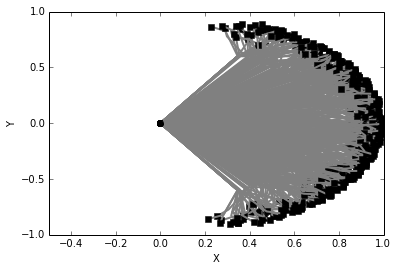

In [10]:
# Random Motor Babbling
ax = axes()
environment.reset()
motor_configurations = environment.random_motors(n=500)

# Plotting 10 random motor configurations:
for m in motor_configurations:
    environment.update(m, reset=False)
    environment.plot(ax)

### Goal Babbling

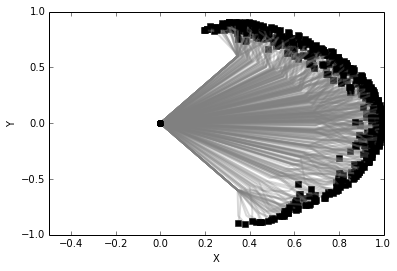

In [11]:
# Random Goal Babbling
im_model = RandomInterest(conf, conf.s_dims)

# Reset environment
environment.reset()

# Reset sensorimotor model
sm_model = SensorimotorModel.from_configuration(conf, 'NN', 'default')

c_dims = [0, 1] # hand position's dimensions

# Add one point to boostrap sensorimotor model
sm_model.update([0.]*6, np.hstack((environment.current_sensori_position, [0., 0.])))
    
ax = axes()

for _ in range(500):
    # Get current context
    s = environment.current_sensori_position
    # sample a random sensory goal using the interest model:
    ds_g = im_model.sample_given_context(s, c_dims)
    #print "sample ds=", ds_g
    # infer a motor command to reach that goal using the sensorimotor model:
    mdm = sm_model.inverse_prediction(np.hstack((s, ds_g)))
    # execute this command and observe the corresponding sensory effect:
    sds = environment.update(mdm, reset=False)
    # update the sensorimotor model:
    sm_model.update(mdm, sds)
    # update interest model
    im_model.update(hstack((mdm, s, ds_g)), hstack((mdm, sds)))
    # plot arm
    environment.plot(ax, alpha=0.3)
    

501
Inverse without context: m = [ 0.50826434  0.01181438  0.92980915] dm = [ 0.09221206  0.03231858 -0.22490492]


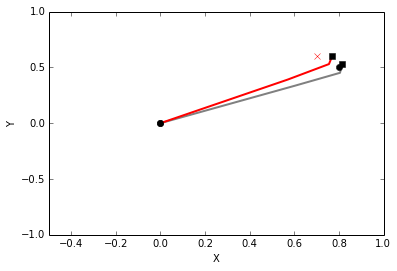

In [12]:
# Inverse without context: (M, dM) <- i(S, dS)
sm_model.mode = "exploit" # no exploration noise
print sm_model.size()
s_goal = [0.8, 0.5]
ds_goal = [-0.1, 0.1]
mdm = sm_model.inverse_prediction(s_goal + ds_goal)
m = mdm[0:3]
dm = mdm[3:6]
print "Inverse without context: m =", m, "dm =", dm 

ax = axes()
environment.update(np.hstack((m, [0]*3)))
environment.plot(ax)
environment.update(np.hstack((m, dm)), reset=False)
environment.plot(ax, color='red')
ax.plot(*s_goal, marker='o', color='k')
ax.plot(*list(np.array(s_goal)+np.array(ds_goal)), marker='x', color='red')

## Using 'Experiment'

Populating the interactive namespace from numpy and matplotlib


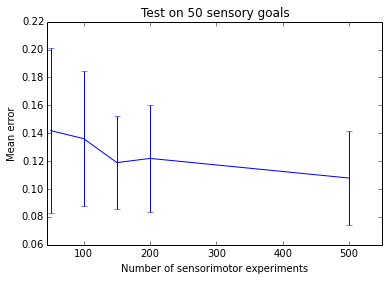

In [13]:
import numpy as np
from explauto import Agent
from explauto import Experiment
from explauto.utils import rand_bounds
from explauto.experiment import make_settings
%pylab inline

context_mode = dict(choose_m=True,
                    context_dims=[0,1],
                    rest_position=[0]*3,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

goal_babbling = make_settings(environment='simple_arm', environment_config = 'low_dimensional',
                                     babbling_mode='goal', 
                                     interest_model='discretized_progress',
                                     sensorimotor_model='NN',
                                     context_mode=context_mode)

expe = Experiment.from_settings(goal_babbling)

expe.evaluate_at([50, 100, 150, 200, 500], 
                 rand_bounds(np.vstack(([0.8, -0.1, -0.1, -0.2], [1., 0.1, 0.1, 0.2])), n=50))

expe.run()

ax = axes()
expe.log.plot_learning_curve(ax)

# V. Learning without choosing m

In [20]:
from explauto.environment.context_environment import ContextEnvironment
from explauto.environment.simple_arm import SimpleArmEnvironment
from explauto.environment import environments

env_cls = SimpleArmEnvironment
env_conf = environments['simple_arm'][1]['low_dimensional']

context_mode = dict(choose_m=False,
                    context_dims=[0,1],
                    rest_position=[0]*3,
                    reset_iterations=20,
                    dm_bounds=[[-0.2, -0.2, -0.2],
                              [0.2, 0.2, 0.2]],
                    ds_bounds=[[-0.2, -0.2],
                              [0.2, 0.2]])

environment = ContextEnvironment(env_cls, env_conf, context_mode)

### Motor Babbling

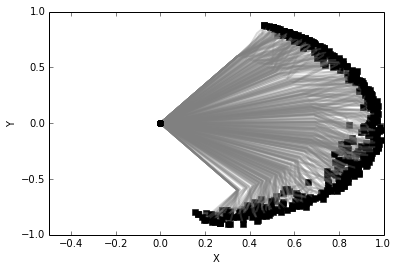

In [15]:
# Random Motor Babbling
ax = axes()
environment.reset()
motor_configurations = environment.random_motors(n=500)

for mdm in motor_configurations:
    
    m = list(environment.current_motor_position)
    environment.update(np.hstack((m, mdm[len(mdm)/2:])), reset=False)
    environment.plot(ax, alpha=0.3)

### Goal Babbling

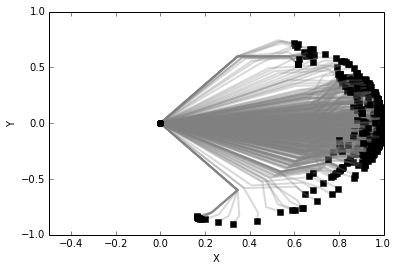

In [16]:
ax = axes()

# Random Goal Babbling
im_model = RandomInterest(conf, conf.s_dims)

# Reset environment
environment.reset()

# Reset sensorimotor model
sm_model = SensorimotorModel.from_configuration(conf, 'NN', 'default')

c_dims = [0, 1] # hand position's dimensions

# Add one point to boostrap sensorimotor model
for i in range(10):
    sm_model.update([0.]*6, np.hstack((environment.current_sensori_position, [0., 0.])))
  

in_dims = range(3) + range(6,10)
out_dims = range(3, 6)

for i in range(500):
    if np.mod(i, context_mode['reset_iterations']) == 0:
        environment.reset()
        #print "Iteration", i, "Reset environment"
    #print
    m = list(environment.current_motor_position)
    s = list(environment.current_sensori_position)

    ds_g = list(im_model.sample_given_context(s, c_dims))
    #print "ds_g", ds_g

    dm = sm_model.infer(in_dims, 
                        out_dims, 
                        m + s + ds_g)
    mdm = np.hstack((m, dm))
    #print "mdm", mdm
    sds = environment.update(mdm, reset=False)
    # update the sensorimotor model:
    sm_model.update(mdm, sds)
    # update interest model
    im_model.update(np.hstack((mdm, s, ds_g)), np.hstack((mdm, sds)))
    # plot arm
    environment.plot(ax, alpha=0.3)
    #print "m", m, "s", s, "ds_g", ds_g, "dm", dm
    

current m =  [0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
current s =  [0.97452003556665556, 0.14665507484753101]
Inverse with context: dm = [ 0.16423409  0.08487866 -0.08701782]
Goal ds= [-0.05, 0.1] Reached ds= [-0.05572757  0.1573319 ]


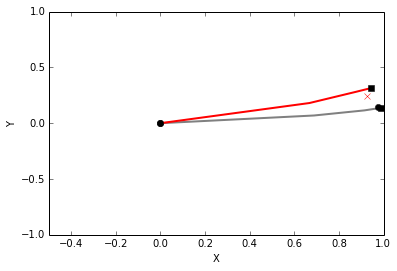

In [17]:
# Inverse with sensorimotor context: dM <- i(M, S, dS)
ax = axes()
dm = [0.1]*3
environment.update(np.hstack(([0]*3, dm)))
environment.plot(ax)

in_dims = range(3) + range(6,10)
out_dims = range(3, 6)
ds_goal = [-0.05, 0.1]

m_current = list(environment.current_motor_position)
s_current = list(environment.current_sensori_position)
print "current m = ", m_current
print "current s = ", s_current

dm = sm_model.infer(in_dims, 
                    out_dims, 
                    m_current + s_current + ds_goal)

print "Inverse with context: dm =", dm 
sds = environment.update(np.hstack((m_current, dm)), reset=False)
environment.plot(ax, color='red')
ax.plot(*s_current, marker='o', color='k')
ax.plot(*list(np.array(s_current) + np.array(ds_goal)), marker='x', color='red')

print "Goal ds=", ds_goal, "Reached ds=", environment.current_sensori_position - s_current




## Using 'Experiment'

Populating the interactive namespace from numpy and matplotlib


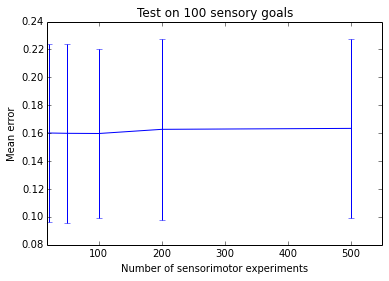

In [19]:
import numpy as np
from explauto import Agent
from explauto import Experiment
from explauto.utils import rand_bounds
from explauto.experiment import make_settings
%pylab inline

goal_babbling = make_settings(environment='simple_arm', environment_config = 'low_dimensional',
                                     babbling_mode='goal', 
                                     interest_model='discretized_progress', # or random
                                     sensorimotor_model='NN', # or LWLR-BFGS, LWLR-CMAES
                                     context_mode=context_mode)

expe = Experiment.from_settings(goal_babbling)

expe.evaluate_at([20, 50, 100, 200, 500], 
                 rand_bounds(np.vstack(([0.8, -0.1, -0.2, -0.2], [1., 0.1, 0.2, 0.2])), n=100))

# Add one point to boostrap sensorimotor model
for i in range(10):
    expe.ag.sensorimotor_model.update([0.]*6, np.hstack((environment.current_sensori_position, [0., 0.])))
    
expe.run()

ax = axes()
expe.log.plot_learning_curve(ax)